In [13]:
from typing import Callable

import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import scienceplots

In [14]:
# CONSTANTEN

# Verzameling van de constanten
class C:
    beta = 4.32e+4
    alpha = 1.11
    k = 3.55e+2
    rB = 1.52
    rS = 0.095
    kE = 1.0
    kS = 2.54e+4
    rE = 0.92
    p = 0.00195
    tE = 0.03

# Standaard labels zodat ze overeenkomen bij alle plots
RUPSEN_LABEL = "Dichtheid rupsen (rupsen/acre)"
WOUD_LABEL = "Dichtheid woud (takken/acre)"
ENERGIE_LABEL = "Relatieve gezondheid"
TIJD_LABEL = "Tijd (jaren)"


In [15]:
# WISKUNDIGE FUNCTIES


def solve_autonomous_system(dXdt: Callable[[np.ndarray], np.ndarray], X0: np.ndarray, time: float, dt: float = 0.001):
    t_arr = np.arange(0, time, dt)
    X_arr = np.empty((t_arr.size, X0.size))
    
    for i in range(len(t_arr)):
        X_arr[i, :] = X0
        X0 += dXdt(X0) * dt
    return t_arr, X_arr


simple_dBdt = lambda S, B:  C.rB*B*(1 - B/(C.k * S)) - C.beta*B**2/((C.alpha*S)**2 + B**2)

def simple_budworm_dXdt(X: np.ndarray) -> np.ndarray:
    # de volgorde is anders dan bij het volle model
    S, B = X

    dBdt = simple_dBdt(S, B)
    dSdt = 400

    return np.array([dSdt, dBdt])


def calculate_roots(n):
    B = sm.symbols("B")
    system = partial(simple_dBdt, B=B)

    root1 = []
    root2 = []
    root3 = []

    for s in np.linspace(150, 25000, num=n):
        roots = sm.nroots(system(s).as_numer_denom()[0])
        real_roots = sorted([r for r in roots if r.is_real])[1:]  # ignore 0 root
        if len(real_roots) == 3:
            r1, r2, r3 = real_roots
            root1.append((s, r1))
            root2.append((s, r2))
            root3.append((s, r3))
        elif len(real_roots) == 2:
            r1, r3 = real_roots
            root1.append((s, r1))
            root3.append((s, r3))
        elif s > 5000:
            root3.append((s, real_roots[0]))
        else:
            root1.append((s, real_roots[0]))
    
    sort = lambda r: tuple(zip(*sorted(r, key=lambda x: x[1])))
    return sort(root1), sort(root2), sort(root3)



In [16]:
# MATPLOTLIB SETUP
plt.style.use(['science', 'ieee'])

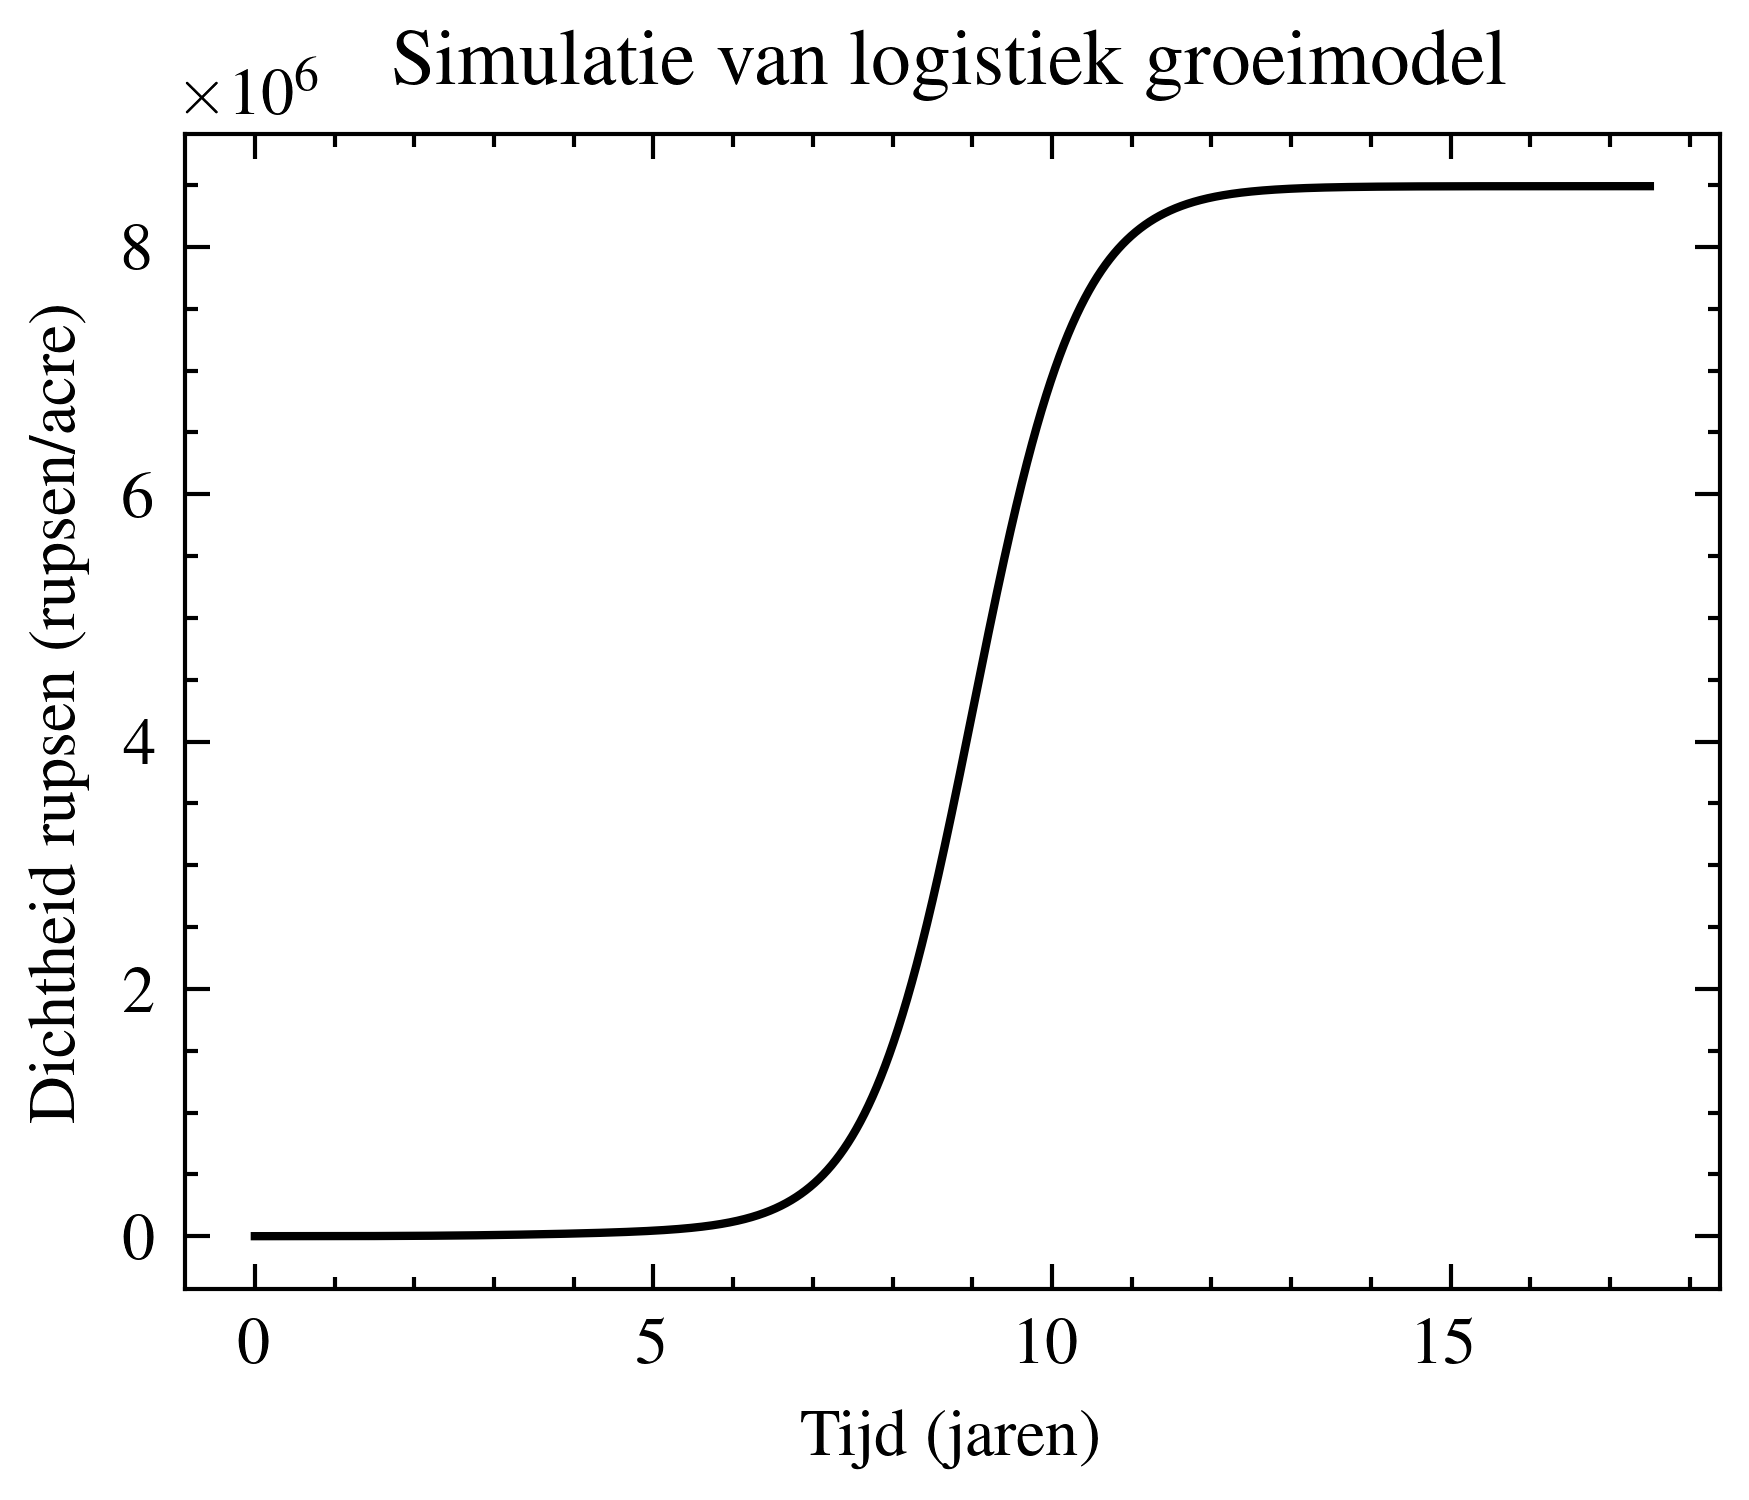

In [29]:
def calculate_logistic():
    system = partial(simple_dBdt, 24000)
    return solve_autonomous_system(system, np.array([150.0]), 17.5)

fig, ax = plt.subplots()
t, y = calculate_logistic()

ax.plot(t, y)
ax.set(xlabel=TIJD_LABEL, ylabel=RUPSEN_LABEL, title="Simulatie van logistiek groeimodel")

plt.savefig("figuren/logistiek.png")

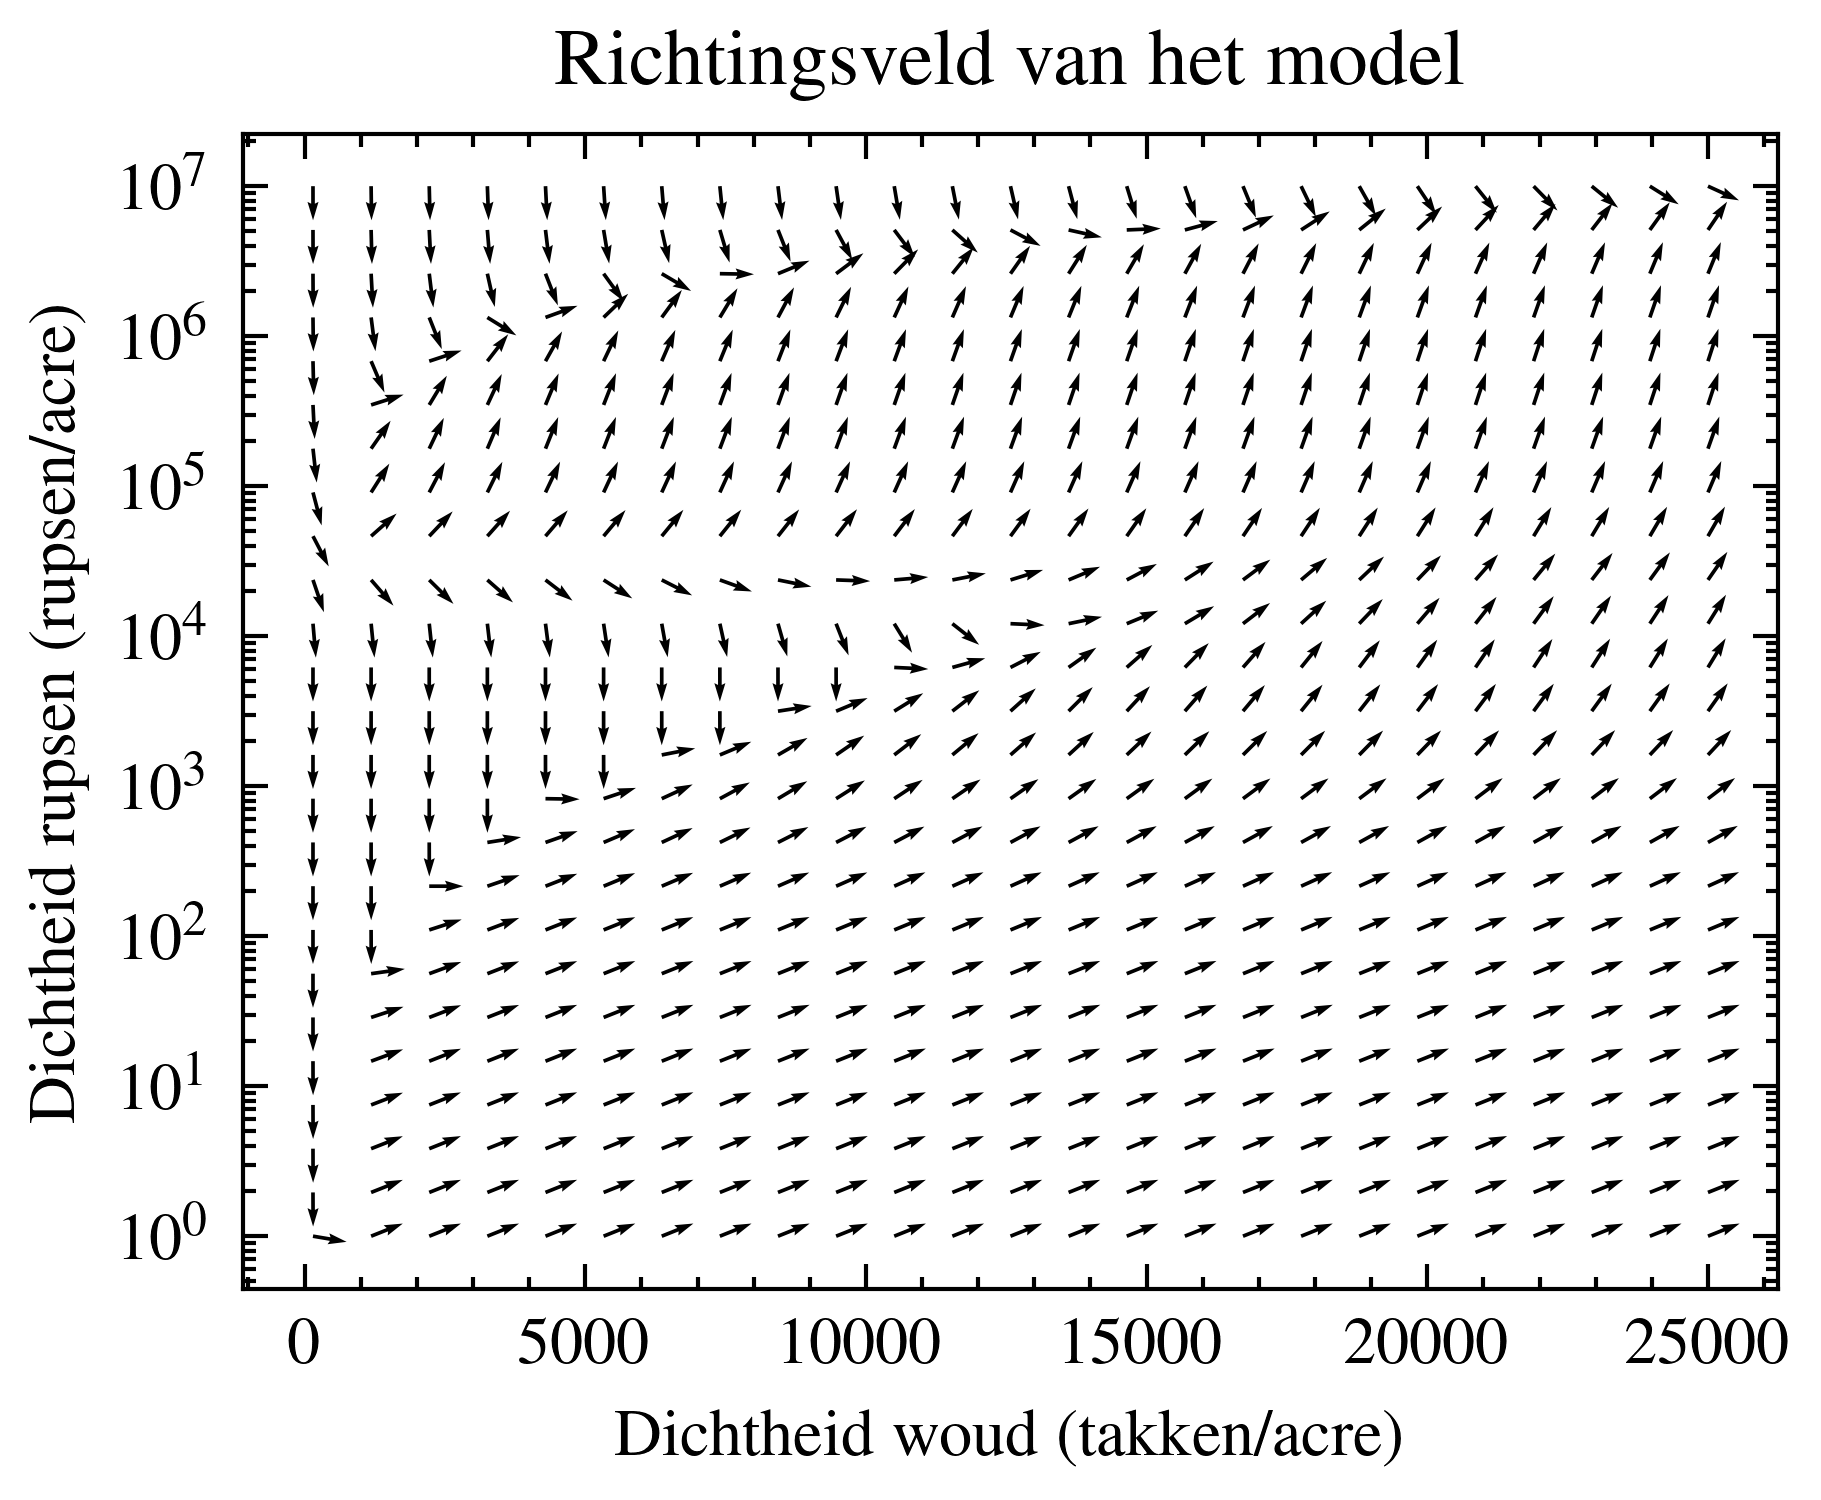

In [30]:
fig, ax = plt.subplots()
density = 25

X, Y = np.meshgrid(np.linspace(150, 25000, num=density), 10 ** np.linspace(0, 7, num=density))

U = 500
V = simple_dBdt(X, Y)
size = np.sqrt(U*U + V*V)

U /= size
V /= size

ax.quiver(X, Y, U, V, angles='xy')

ax.set(title='Richtingsveld van het model', xlabel=WOUD_LABEL, ylabel=RUPSEN_LABEL, yscale='log')

plt.savefig("figuren/richtingsveld-woud.png")

In [31]:
r1, r2, r3 = calculate_roots(1000)

In [25]:
def find_saddle_point():
    S, B = sm.symbols("S B")
    eq = simple_dBdt(S, B)
    return sm.nsolve([eq, sm.diff(eq, B)], (S, B), (10000, 10000))

saddle_point = find_saddle_point()
saddle_point

Matrix([
[12842.4945396396],
[14300.0933838794]])

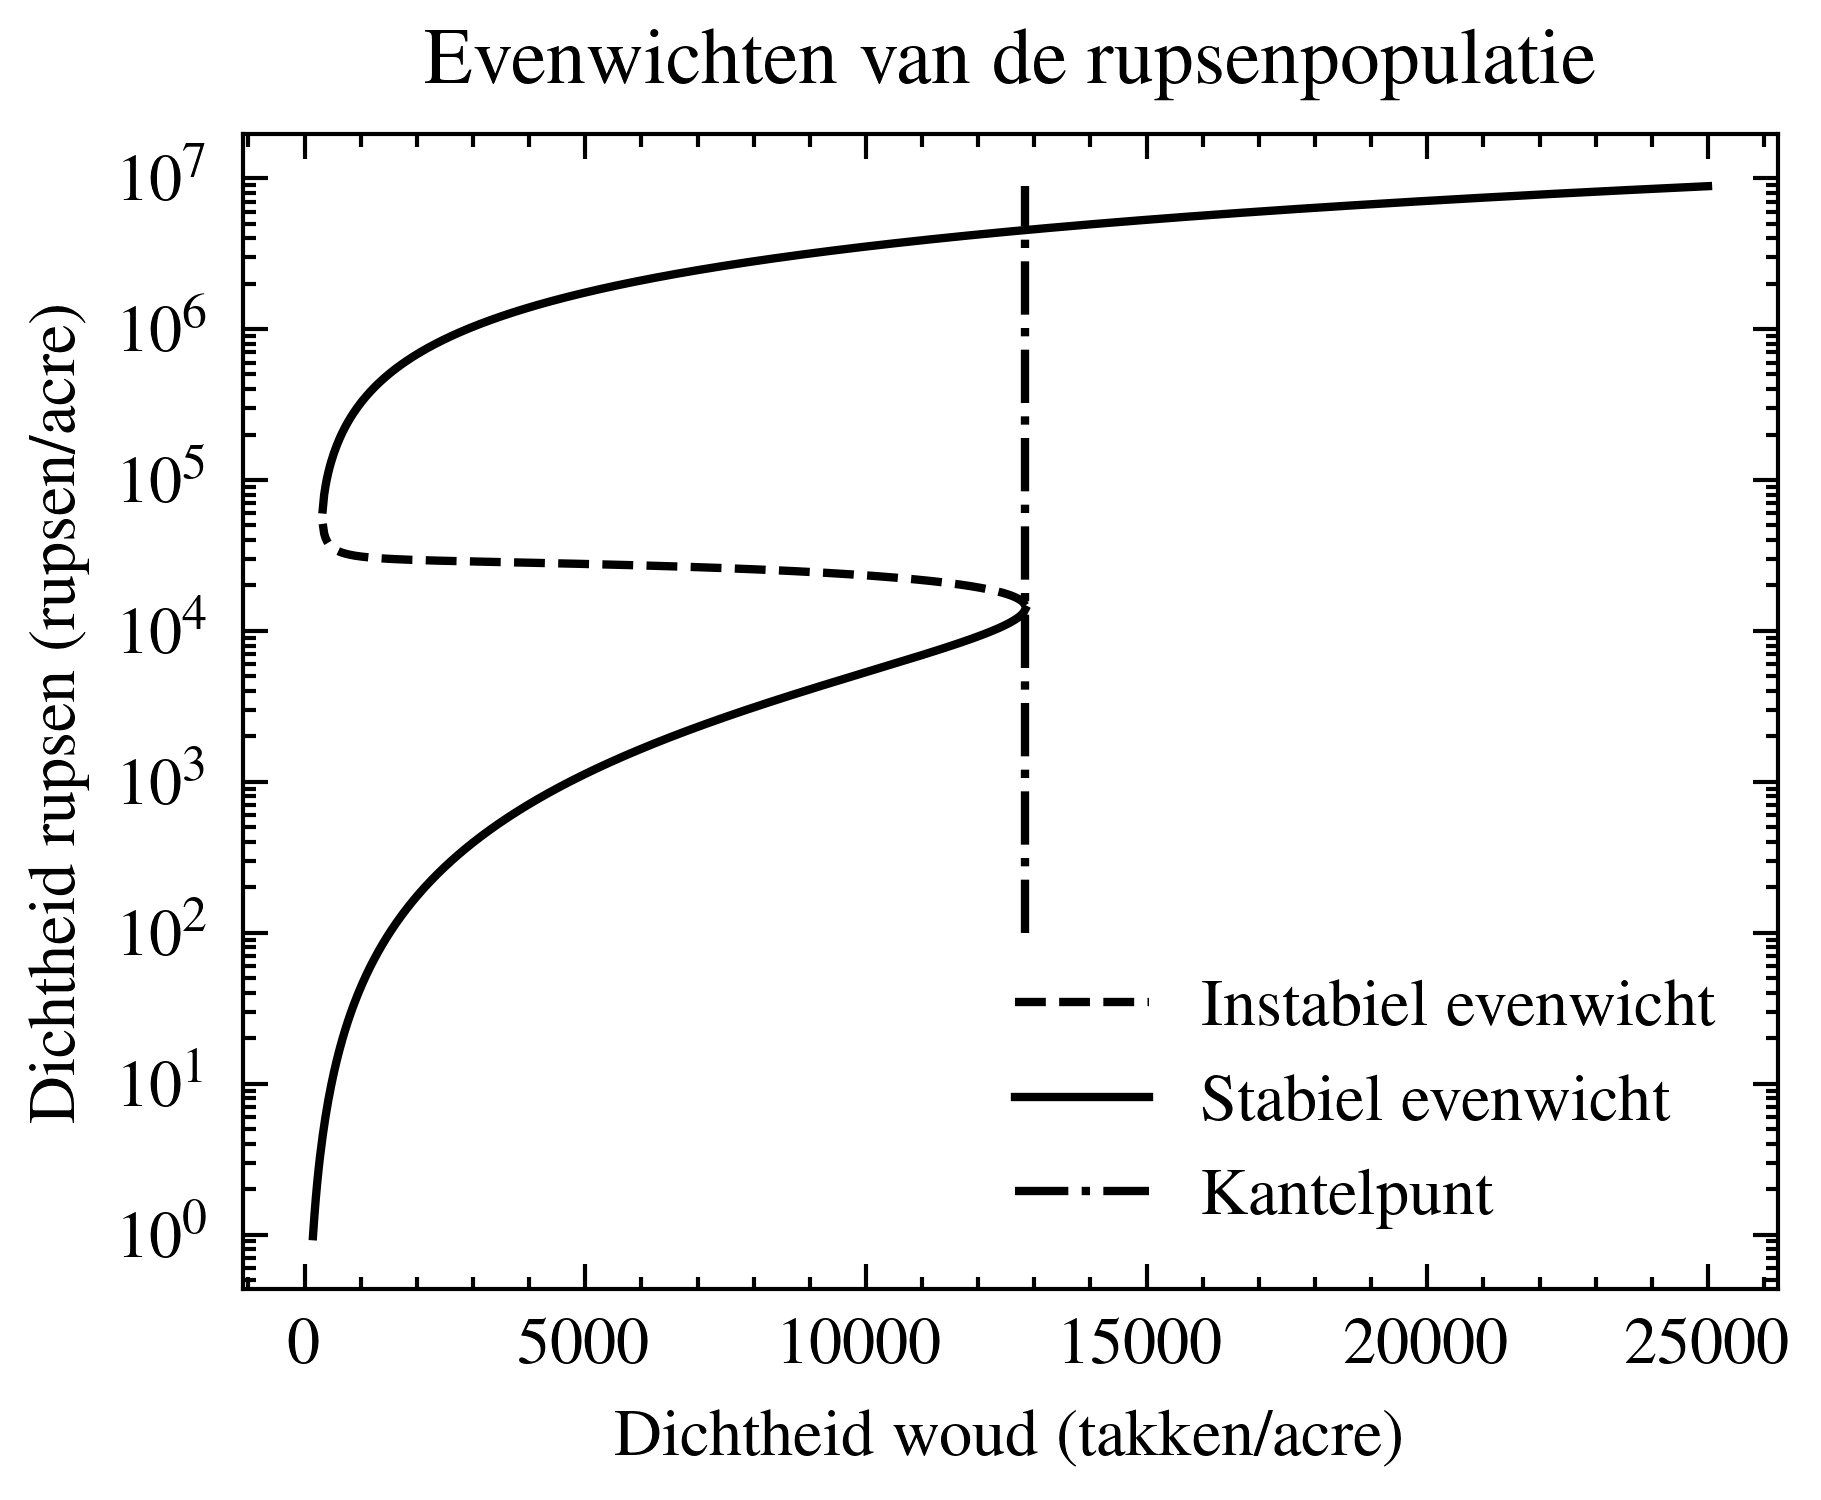

In [32]:
fig, ax = plt.subplots()

ax.plot(*r1)
ax.plot(*r2, color='black', label='Instabiel evenwicht')
ax.plot(*r3, linestyle='solid', color='black', label='Stabiel evenwicht')
# ax.scatter(*saddle_point, s=10, label="Kantelpunt")
ax.vlines(saddle_point[0], 100, np.max(r3[1]), linestyle='dashdot', zorder=-1, label='Kantelpunt')
ax.set(xlabel=WOUD_LABEL, ylabel=RUPSEN_LABEL, title='Evenwichten van de rupsenpopulatie', yscale='log')

ax.legend()

plt.savefig("figuren/evenwichten.png")

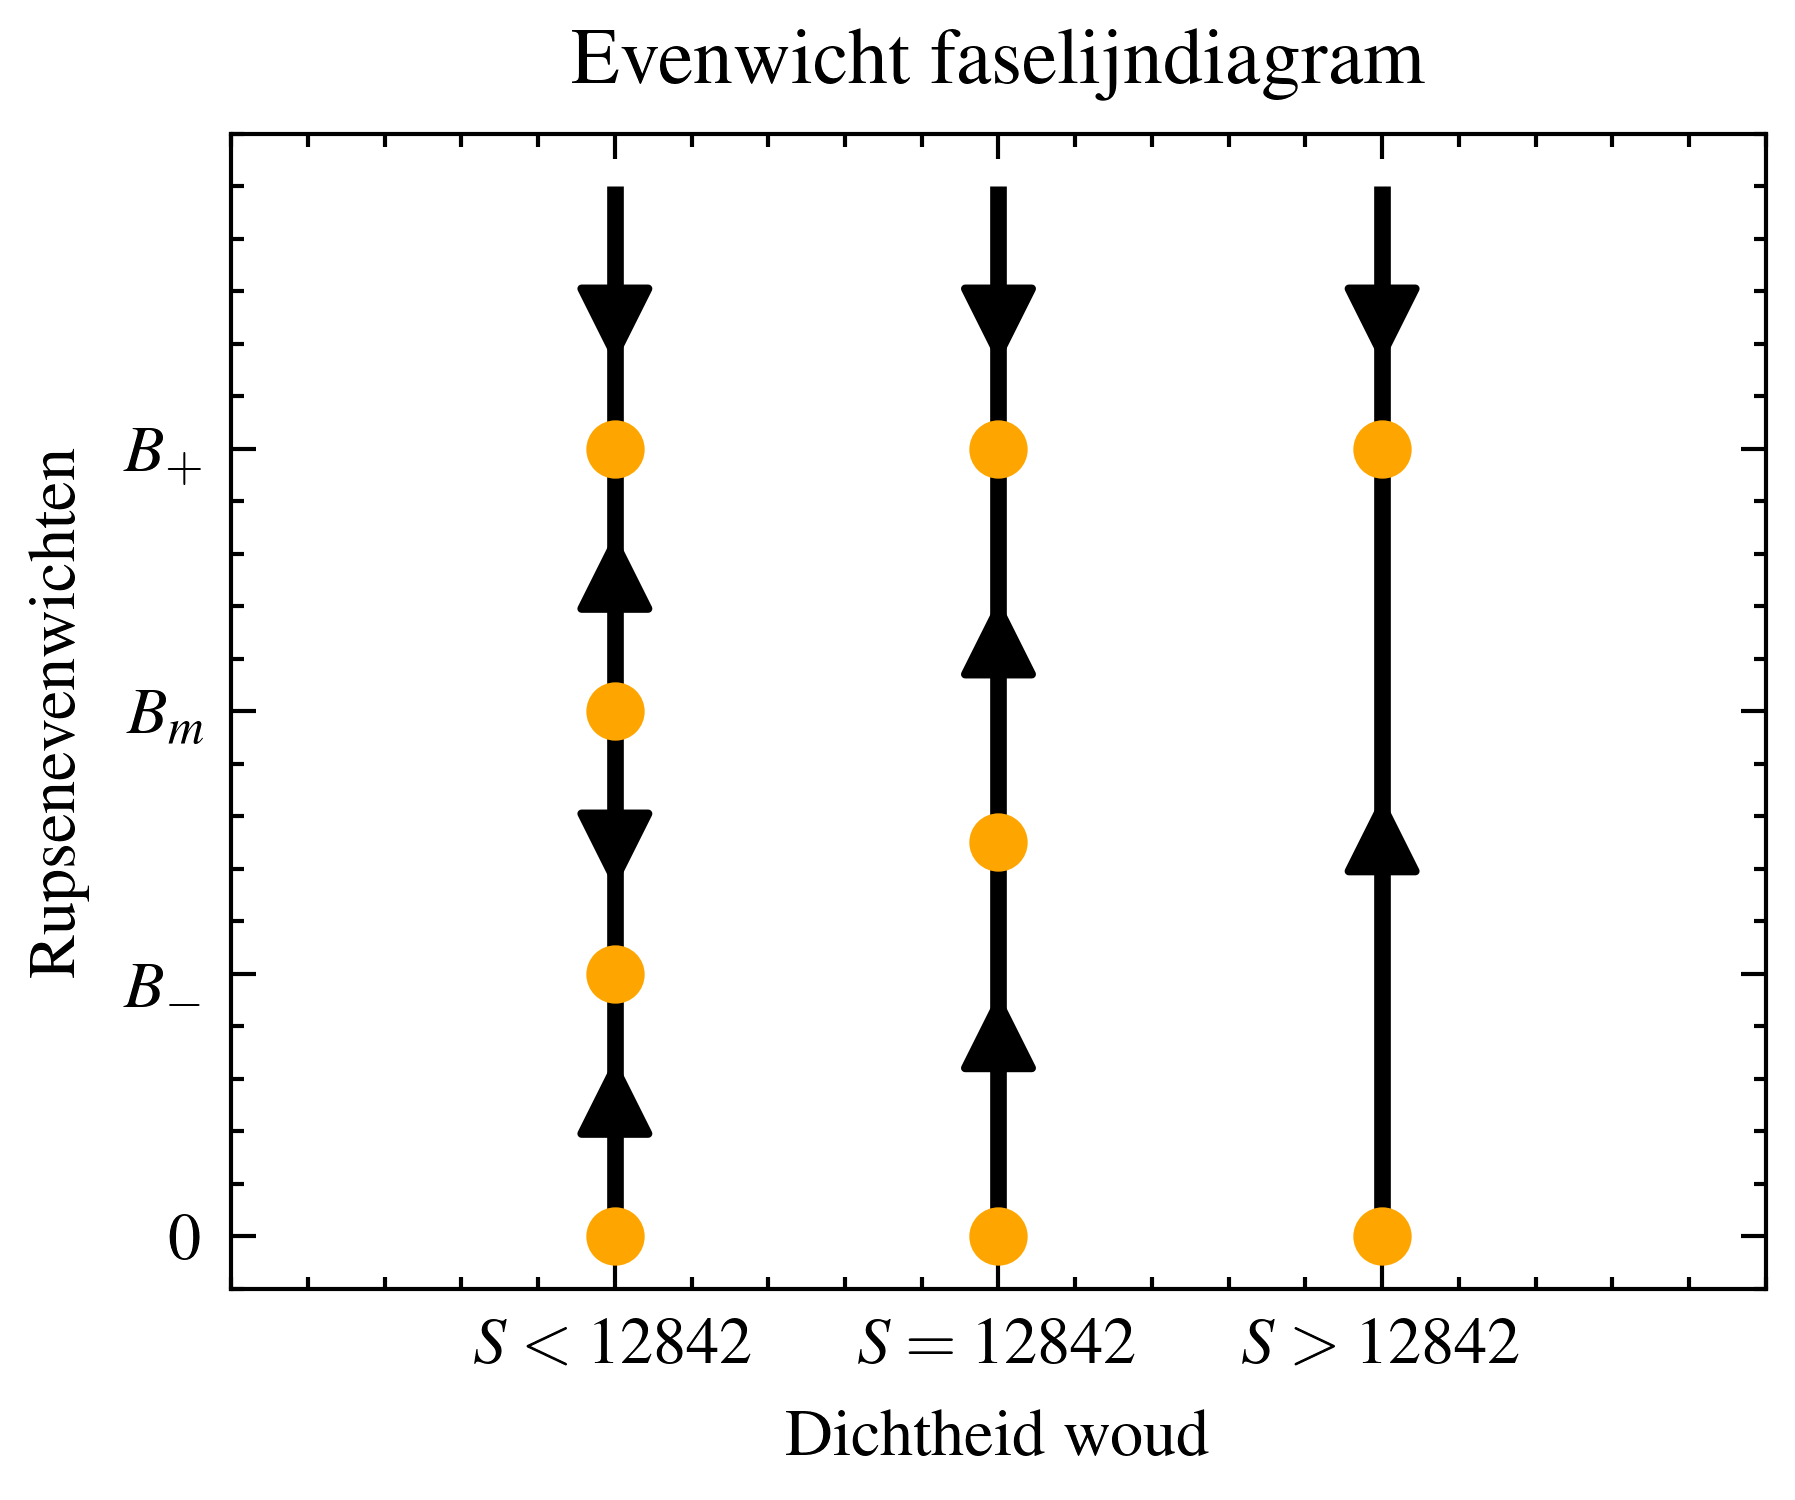

In [34]:
fig, ax = plt.subplots()

def arrow_between(x1, y1, x2, y2):
    centre_offset = 0.09 if y2 > y1 else -0.09
    ax.annotate('', ((x1 + x2) / 2, (y1 + y2) / 2 + centre_offset), (x1, y1), arrowprops={"arrowstyle": "-|>", "shrinkB": 0}, size=20)

def equi(x, e_arr, d_arr):
    ax.vlines(x, 0, 2, linewidth=2)
    for i, p in enumerate(e_arr):
        if i == len(e_arr) - 1:
            arrow_between(x, 2.0, x, p)
        elif d_arr[i]:

            arrow_between(x, p, x, e_arr[i + 1])
        else:
            arrow_between(x, e_arr[i + 1], x, p)
        ax.scatter(x, p, color="orange", zorder=3)

equi(0.5, [0.0, 0.5, 1.0, 1.5], [1, 0, 1, 0])

equi(1.0, [0.0, 0.75, 1.5], [1, 1, 0])

equi(1.5, [0.0, 1.5], [1, 0])


xlabels = {0.5: r"$S < 12842$", 1.0: r"$S = 12842$", 1.5: r"$S > 12842$"}

ax.set(xlim=(0.0, 2.0), title="Evenwicht faselijndiagram", ylabel="Rupsenevenwichten", xlabel="Dichtheid woud")

ax.set_xticks([0.5, 1.0, 1.5], labels=["$S < 12842$", "$S = 12842$", "$S > 12842$"])
ax.set_yticks([0.0, 0.5, 1.0, 1.5], labels=["0", "$B_-$", "$B_m$", "$B_+$"])

plt.savefig("figuren/faselijn.png")

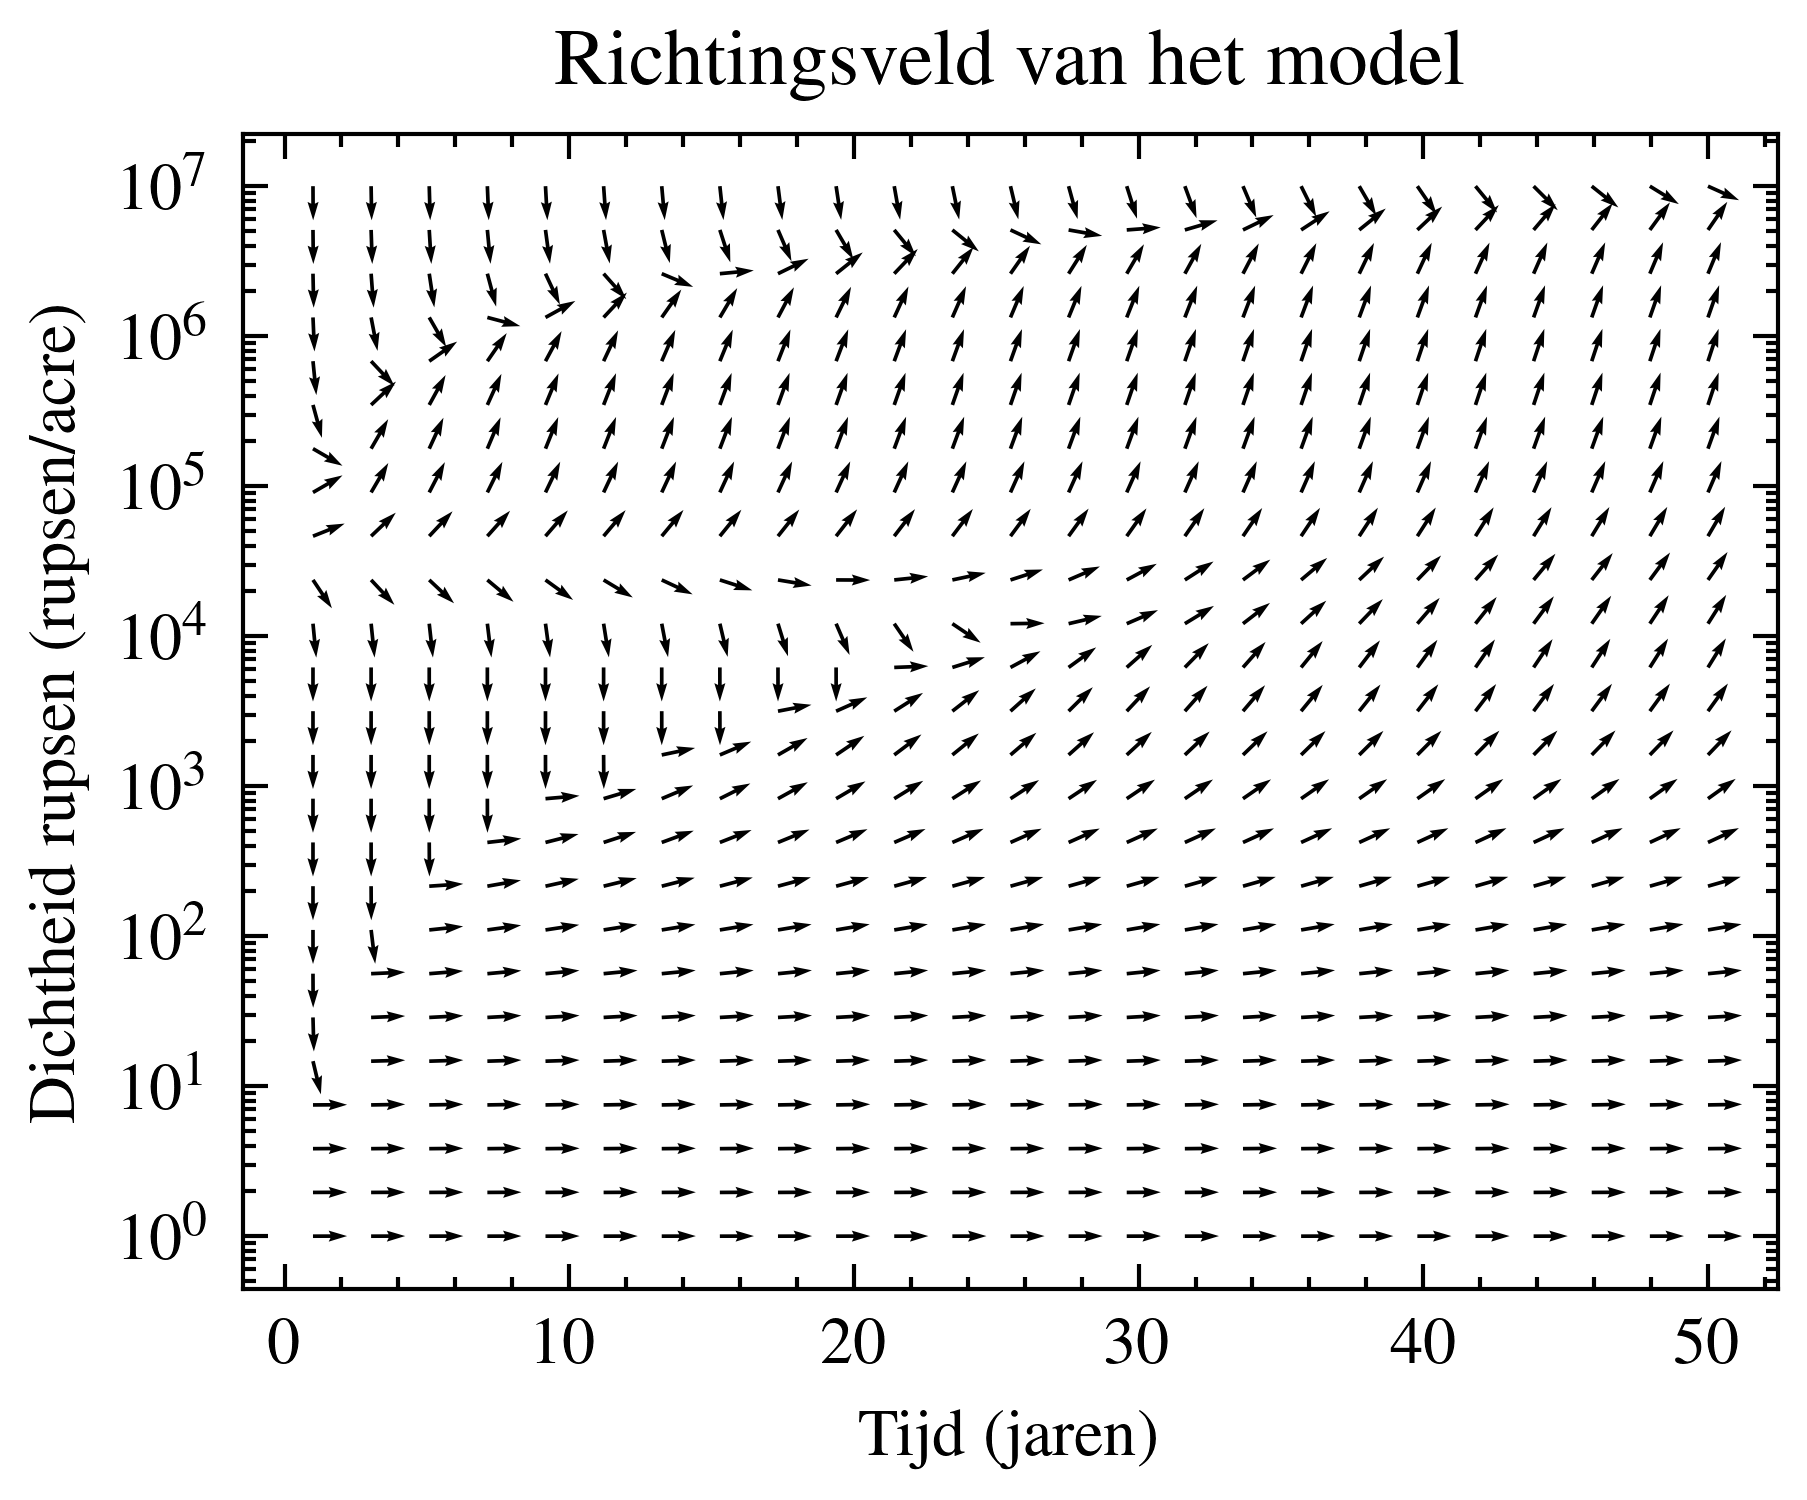

In [37]:
dBdt = lambda t, B: C.rB * B * (1 - B / (500 * C.k * t)) - C.beta * B**2 / (C.alpha**2 * (500*t)**2 + B**2)

fig, ax = plt.subplots()
density = 25

X, Y = np.meshgrid(np.linspace(1, 50, num=density), 10 ** np.linspace(0, 7, num=density))

U = 1
V = dBdt(X, Y)
size = np.sqrt(U*U + V*V)

U /= size
V /= size

ax.quiver(X, Y, U, V, angles='xy')

ax.set(title='Richtingsveld van het model', xlabel=TIJD_LABEL, ylabel=RUPSEN_LABEL, yscale='log')

plt.savefig("figuren/richtingsveld-tijd.png")